In [2]:
import os
from PIL import Image
import numpy as np
import keras
import cv2
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import random


vggModel = VGG16(weights='imagenet', include_top=False)
resModel = ResNet50(weights='imagenet',include_top=False)
xceptionModel = Xception(weights='imagenet',include_top=False)
mobilenetModel = MobileNetV2(weights='imagenet',include_top=False)
inceptionModel = InceptionV3(weights='imagenet',include_top=False)
densenetModel = DenseNet121(weights='imagenet',include_top=False)

model = resModel

X = []
Y = []
classCount = 0

basepath='./dataset/'
for folder in os.scandir(basepath):
    if folder.is_dir():
        for imfile in os.scandir(folder.path):
            image = Image.open(imfile.path)
            image = np.array(image.resize((224,224)))
            image = image.reshape([-1,224,224,3])
            feature=(model.predict([image])).flatten()
            X.append(feature)
            Y.append(folder.name)
        classCount+=1
X = np.array(X)

1/1 [==============================] - 3s 3s/step


In [3]:
print(np.shape(X))
print(np.shape(Y))

(42, 100352)
(42,)


In [4]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, Y)
model = SelectFromModel(clf, prefit=True)
X = model.transform(X)

print(np.shape(X))
print(np.shape(Y))

(42, 249)
(42,)


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
y = encoder.fit_transform(Y)
print(y)        
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=42)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


dnnModel=models.Sequential()
dnnModel.add(layers.Dense(10000,activation="relu",input_shape=(np.shape(X)[1],)))
dnnModel.add(layers.Dense(5000,activation="relu"))
dnnModel.add(layers.Dense(2000,activation="relu"))
dnnModel.add(layers.Dense(500,activation="relu"))
dnnModel.add(layers.Dense(300,activation="relu"))
dnnModel.add(layers.Dense(200,activation="relu"))
dnnModel.add(layers.Dense(120,activation="relu"))
dnnModel.add(layers.Dense(30,activation="relu"))
dnnModel.add(layers.Dense(30,activation="relu"))
dnnModel.add(layers.Dense(1,activation="sigmoid"))
dnnModel.summary()


dnnModel.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])


dnnModel.fit(X_train,y_train,epochs=25,batch_size=4)

testloss, testAccuracy=dnnModel.evaluate(X_test,y_test)

print(testAccuracy)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10000)             2500000   
                                                                 
 dense_1 (Dense)             (None, 5000)              50005000  
                                                                 
 dense_2 (Dense)             (None, 2000)              10002000  
                                                                 
 dense_3 (Dense)             (None, 500)               1000500   
                                                                 
 dense_4 (Dense)             (None, 300)               150300    
                                                                 
 dense_5 (Dense)             (None, 200)               60200     
                                   

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = SVC()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('svm', clf4)],
    voting='hard')

acc=[]
for clf, label in zip([clf1, clf2, clf3,clf4, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM','Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=2)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    acc.append(scores.mean())
sns.barplot(x=['LR', 'RF', 'NB', 'SVM','Ensemble'],y=acc)

Accuracy: 1.00 (+/- 0.00) [Logistic Regression]
Accuracy: 1.00 (+/- 0.00) [Random Forest]
Accuracy: 0.93 (+/- 0.02) [Naive Bayes]
Accuracy: 1.00 (+/- 0.00) [SVM]
Accuracy: 1.00 (+/- 0.00) [Ensemble]


In [ ]:
clf1.fit(X_train,y_train)
cm = confusion_matrix(y_test,clf1.predict(X_test))
sns.heatmap(cm,annot=True,xticklabels=encoder.inverse_transform([0,1]),yticklabels=encoder.inverse_transform([0,1]),cmap='Greens')

In [ ]:
clf2.fit(X_train,y_train)
cm = confusion_matrix(y_test,clf2.predict(X_test))
sns.heatmap(cm,annot=True,xticklabels=encoder.inverse_transform([0,1]),yticklabels=encoder.inverse_transform([0,1]),cmap='Blues')

In [ ]:
clf3.fit(X_train,y_train)
cm = confusion_matrix(y_test,clf3.predict(X_test))
sns.heatmap(cm,annot=True,xticklabels=encoder.inverse_transform([0,1]),yticklabels=encoder.inverse_transform([0,1]),cmap='Oranges')

<Axes: >

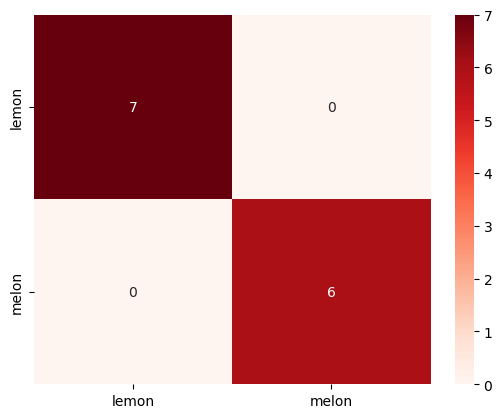

In [14]:
clf4.fit(X_train,y_train)
cm = confusion_matrix(y_test,clf4.predict(X_test))
sns.heatmap(cm,annot=True,xticklabels=encoder.inverse_transform([0,1]),yticklabels=encoder.inverse_transform([0,1]), cmap='Reds')

<Axes: >

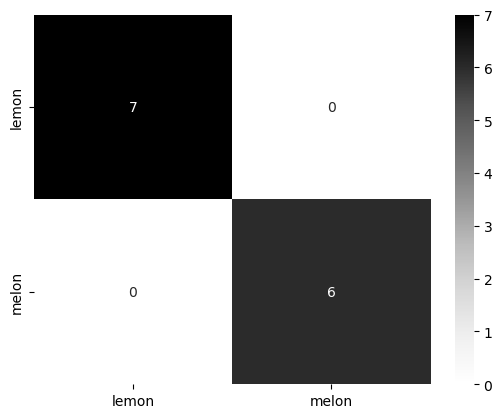

In [15]:
eclf.fit(X_train,y_train)
cm = confusion_matrix(y_test,eclf.predict(X_test))
sns.heatmap(cm,annot=True,xticklabels=encoder.inverse_transform([0,1]),yticklabels=encoder.inverse_transform([0,1]),cmap='Greys')